# Housing Price Index TSA - VAR model

### Importing the libraries

In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Importing the dataset(s)

In [2]:
weekly_factors = pd.read_csv('./Data/HPP_Weekly.csv',parse_dates=['DATE'],dayfirst=True, index_col = 'DATE')
monthly_factors = pd.read_csv('./Data/HPP_monthly.csv',parse_dates=['DATE'],dayfirst=True, index_col = 'DATE')
quaterly_factors = pd.read_csv('./Data/HPP_quaterly.csv',parse_dates=['DATE'],dayfirst=True, index_col = 'DATE')

### EDA

In [3]:
weekly_factors = weekly_factors.resample('QS').mean()

In [4]:
weekly_factors

,Mortgage_rate
DATE,
1993-01-01,7.723333
1993-04-01,7.453077
1993-07-01,7.087692
1993-10-01,7.046429
1994-01-01,7.295833
...,...
2021-04-01,3.003846
2021-07-01,2.872143
2021-10-01,3.079231


In [5]:
monthly_factors = monthly_factors.resample('QS').mean()

In [6]:
monthly_factors

,Permit_totals,New_construction,New_units_sold_total,Unemployment_rate,CS_HPI,Pvt_const_cost
DATE,,,,,,
1993-01-01,1127.000000,1167.666667,600.666667,7.133333,76.829667,193008.000000
1993-04-01,1115.333333,1266.000000,660.000000,7.066667,77.071667,200102.000000
1993-07-01,1218.333333,1299.000000,675.333333,6.800000,77.611667,211814.666667
1993-10-01,1368.333333,1433.666667,761.666667,6.633333,78.138333,225887.000000
1994-01-01,1333.666667,1391.000000,684.000000,6.566667,78.724667,236779.666667
...,...,...,...,...,...,...
2020-10-01,1670.333333,1574.000000,907.666667,6.766667,232.536000,684464.666667
2021-01-01,1786.333333,1581.000000,853.333333,6.200000,242.128667,735176.666667
2021-04-01,1705.666667,1591.333333,754.333333,5.900000,254.657667,765465.666667


In [7]:
quaterly_factors

,GDP_inflation_adjusted,Delinquency_foreclosures_rate
DATE,,
1993-01-01,9857.185,2.82
1993-04-01,9914.565,2.58
1993-07-01,9961.873,2.59
1993-10-01,10097.362,2.45
1994-01-01,10195.338,2.47
...,...,...
2021-01-01,19055.655,2.66
2021-04-01,19368.310,2.41
2021-07-01,19478.893,2.30


In [8]:
data_combined = pd.merge(monthly_factors,weekly_factors, on = 'DATE',how = 'inner')
data_combined = pd.merge(data_combined,quaterly_factors, on = 'DATE', how= 'inner')

In [9]:
data_agg = data_combined

In [10]:
data_agg.shape

(116, 9)

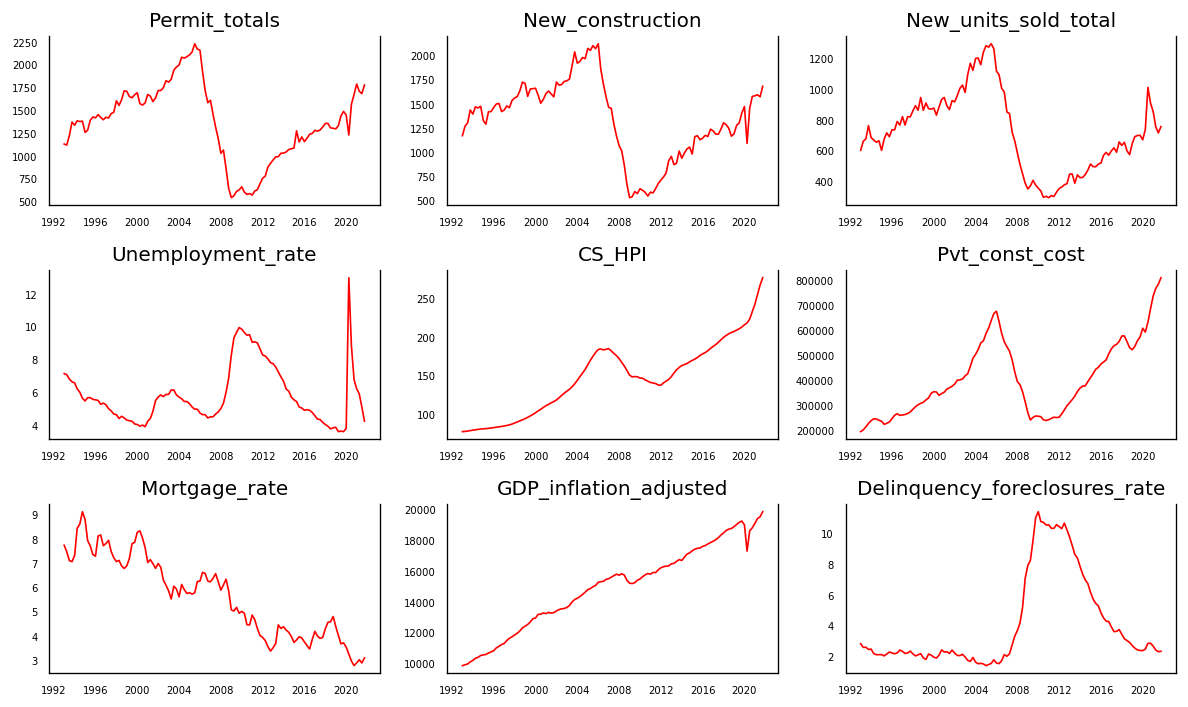

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=3, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = data_agg[data_agg.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(data_agg.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

#### Checking for Stationarity

In [12]:
for i in data_agg.columns:
    ad_fuller_result = adfuller(data_agg[i].diff()[1:])

    print(i)
    print(f'ADF Statistic: {ad_fuller_result[0]}')
    print(f'p-value: {ad_fuller_result[1]}')
    print('\n---------------------\n')
    
    

Permit_totals
ADF Statistic: -2.692841786187608
p-value: 0.07528516482707873

---------------------

New_construction
ADF Statistic: -3.1298421508645964
p-value: 0.02442212191908763

---------------------

New_units_sold_total
ADF Statistic: -2.6473247072622463
p-value: 0.0836052547808721

---------------------

Unemployment_rate
ADF Statistic: -12.502859084318933
p-value: 2.7816588325121243e-23

---------------------

CS_HPI
ADF Statistic: -2.1694612437598333
p-value: 0.21751533061538664

---------------------

Pvt_const_cost
ADF Statistic: -2.5775275807763554
p-value: 0.09773137524887826

---------------------

Mortgage_rate
ADF Statistic: -7.7378099158366
p-value: 1.0818669345303182e-11

---------------------

GDP_inflation_adjusted
ADF Statistic: -12.858878809627814
p-value: 5.161193535371101e-24

---------------------

Delinquency_foreclosures_rate
ADF Statistic: -2.9919539891909577
p-value: 0.03565265912725884

---------------------



In [13]:
for i in range(len(data_agg.columns)-1):
    j = i+1
    print(f'\n\n{data_agg.columns[i]} causes {data_agg.columns[j]}?\n')
    print('------------------')
    granger_1 = grangercausalitytests(data_agg[[data_agg.columns[i],data_agg.columns[j]]], 4)
    
    print(f'\n\n{data_agg.columns[j]} causes {data_agg.columns[i]}?\n')
    print('------------------')
    granger_2 = grangercausalitytests(data_agg[[data_agg.columns[j], data_agg.columns[i]]], 4)



Permit_totals causes New_construction?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1761  , p=0.6755  , df_denom=112, df_num=1
ssr based chi2 test:   chi2=0.1809  , p=0.6706  , df=1
likelihood ratio test: chi2=0.1807  , p=0.6708  , df=1
parameter F test:         F=0.1761  , p=0.6755  , df_denom=112, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4639  , p=0.6301  , df_denom=109, df_num=2
ssr based chi2 test:   chi2=0.9703  , p=0.6156  , df=2
likelihood ratio test: chi2=0.9662  , p=0.6169  , df=2
parameter F test:         F=0.4639  , p=0.6301  , df_denom=109, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8435  , p=0.4731  , df_denom=106, df_num=3
ssr based chi2 test:   chi2=2.6975  , p=0.4407  , df=3
likelihood ratio test: chi2=2.6658  , p=0.4461  , df=3
parameter F test:         F=0.8435  , p=0.4731  , df_denom=106, df_num=3

Granger Causality
number of lags

In [14]:
for i in range(len(data_agg.columns)):
    j = data_agg.columns[4]
    print(f'\n\n{data_agg.columns[i]} causes {j}?\n')
    print('------------------')
    granger_1 = grangercausalitytests(data_agg[[data_agg.columns[i],j]], 4)
    
    print(f'\n\n{j} causes {data_agg.columns[i]}?\n')
    print('------------------')
    granger_2 = grangercausalitytests(data_agg[[j, data_agg.columns[i]]], 4)



Permit_totals causes CS_HPI?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1197  , p=0.2923  , df_denom=112, df_num=1
ssr based chi2 test:   chi2=1.1497  , p=0.2836  , df=1
likelihood ratio test: chi2=1.1440  , p=0.2848  , df=1
parameter F test:         F=1.1197  , p=0.2923  , df_denom=112, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=12.0977 , p=0.0000  , df_denom=109, df_num=2
ssr based chi2 test:   chi2=25.3053 , p=0.0000  , df=2
likelihood ratio test: chi2=22.8535 , p=0.0000  , df=2
parameter F test:         F=12.0977 , p=0.0000  , df_denom=109, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.8432  , p=0.0001  , df_denom=106, df_num=3
ssr based chi2 test:   chi2=25.0834 , p=0.0000  , df=3
likelihood ratio test: chi2=22.6531 , p=0.0000  , df=3
parameter F test:         F=7.8432  , p=0.0001  , df_denom=106, df_num=3

Granger Causality
number of lags (no zero)

### Train - validation(test) split

In [15]:
train = data_agg[:-12]
valid = data_agg[-12:]

### Model Training

In [16]:
model = VAR(train.diff()[1:])

In [17]:
sorted_order=model.select_order(maxlags=5)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       44.37       44.60   1.852e+19       44.46
1       40.60      42.97*   4.315e+17      41.56*
2       40.39       44.90  3.618e+17*       42.21
3       40.61       47.26   5.037e+17       43.30
4       40.10       48.88   3.702e+17       43.65
5      40.04*       50.96   5.000e+17       44.45
-------------------------------------------------


In [18]:
var_model = VARMAX(train, order=(4,0),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

                                                                                                               Statespace Model Results                                                                                                               
Dep. Variable:     ['Permit_totals', 'New_construction', 'New_units_sold_total', 'Unemployment_rate', 'CS_HPI', 'Pvt_const_cost', 'Mortgage_rate', 'GDP_inflation_adjusted', 'Delinquency_foreclosures_rate']   No. Observations:                  104
Model:                                                                                                                                                                                                 VAR(4)   Log Likelihood               -8856.040
                                                                                                                                                                                                  + intercept   AIC                          18468.079
Date:       

### Prediction

In [20]:
n_forecast = 12
predict = fitted_model.get_prediction(start=len(train),end=len(train) + n_forecast-1)

predictions=predict.predicted_mean

In [21]:
predictions.columns=[x+'_pred' for x in train.columns]
predictions

,Permit_totals_pred,New_construction_pred,New_units_sold_total_pred,Unemployment_rate_pred,CS_HPI_pred,Pvt_const_cost_pred,Mortgage_rate_pred,GDP_inflation_adjusted_pred,Delinquency_foreclosures_rate_pred
2019-01-01,1376.269604,1341.077667,696.869815,4.648802,206.951687,532710.522210,2.131372,18615.270405,2.786677
2019-04-01,1338.547296,1306.515295,674.013577,4.904025,209.851228,523612.426364,2.117681,18700.243752,2.650177
2019-07-01,1306.145491,1276.669572,654.118795,5.144482,212.539666,516181.221857,2.146767,18771.386023,2.453865
2019-10-01,1305.157219,1278.318171,655.257519,5.220120,212.441190,510414.166153,2.321458,18642.872944,2.227523
2020-01-01,1309.039682,1284.344830,659.429537,5.271920,212.178123,506400.788159,2.429741,18507.689004,2.094450
2020-04-01,1274.944655,1251.206143,639.106814,5.470779,212.713684,499718.392357,2.534735,18497.959726,2.033314
2020-07-01,1270.969034,1249.507692,638.900710,5.527772,209.511427,489942.784808,2.893605,18258.515952,1.946260
2020-10-01,1265.048390,1244.513523,637.000806,5.561623,208.430044,484789.828493,3.111032,18139.718700,1.824645
2021-01-01,1256.071897,1236.141695,633.209452,5.628825,206.076899,477796.309877,3.334880,17971.802784,1.793930
2021-04-01,1249.511198,1230.710287,630.950268,5.694200,202.421010,468378.247133,3.604887,17750.128192,1.824416


In [22]:
test_vs_pred=pd.concat([valid,predictions],axis=1)

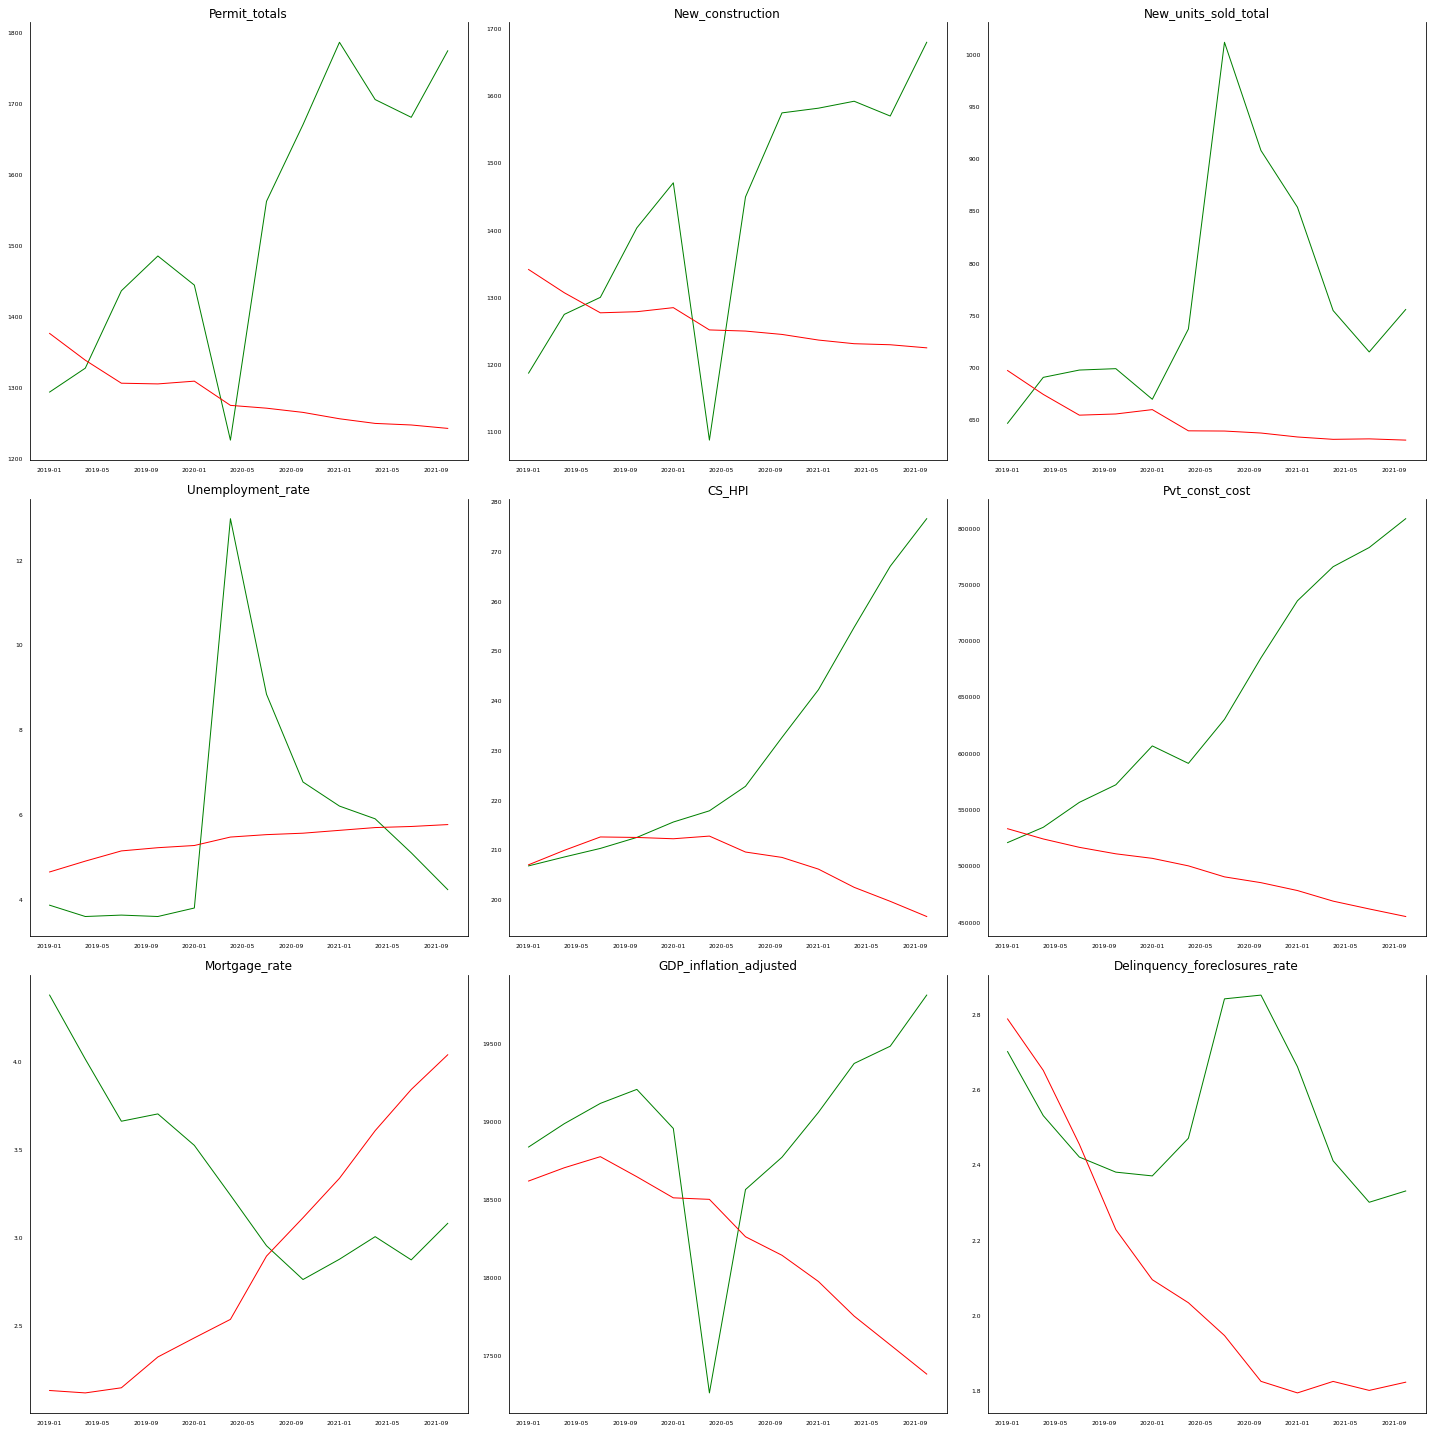

In [42]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,20))
for i, ax in enumerate(axes.flatten()):
    data1 = valid[valid.columns[i]]
    ax.plot(data1, color='green', linewidth=1)
    data2 = predictions[predictions.columns[i]]
    ax.plot(data2, color='red', linewidth=1)
    # Decorations
    ax.set_title(valid.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [43]:
from sklearn.metrics import mean_squared_error
import math 
from statistics import mean
for i in valid.columns:
    rmse=math.sqrt(mean_squared_error(predictions[i+'_pred'],valid[i]))
    print('Mean value of {} is : {}. Root Mean Squared Error is :{}'.format(i,mean(valid[i]),rmse))


Mean value of Permit_totals is : 1532.7222222222222. Root Mean Squared Error is :327.3770252825043
Mean value of New_construction is : 1430.4166666666667. Root Mean Squared Error is :261.6832128575631
Mean value of New_units_sold_total is : 761.2777777777778. Root Mean Squared Error is :161.86917259248497
Mean value of Unemployment_rate is : 5.708333333333333. Root Mean Squared Error is :2.5989011447722357
Mean value of CS_HPI is : 230.55808333333331. Root Mean Squared Error is :36.224470312180394
Mean value of Pvt_const_cost is : 648737.0. Root Mean Squared Error is :197016.70850190433
Mean value of Mortgage_rate is : 3.3373267704517704. Root Mean Squared Error is :1.191379757370411
Mean value of GDP_inflation_adjusted is : 18948.21525. Root Mean Squared Error is :1159.0649512563084
Mean value of Delinquency_foreclosures_rate is : 2.5216666666666665. Root Mean Squared Error is :0.5599986698812409


Not the best model to find predict anything in this case. Covid messes up the stationarity. Will use LSTM next.